### Introduction

The purpose of this notebook is to serve as a demonstration of the two main recommender models used in this project, and will take an in-depth look at how it is that the models are constructed and trained. At the end the models built using various methods will be compared in an attempt to show which hyperparameters, and data formatting techniques show the most strongly related results.

Each of the methods was trained using the same MovieLens dataset, which is a sparsely-populated matrix which holds user ratings for selected movies. The goal of this project was to implemented two different methods of implementing a recommender system using this data, and finding the correlation between these methods.

### Matrix Factorization

The first methods that was implemented was the matrix factorization method. This involves choosing a number of factors, then creating a user and item matrix, in order to generate predicted user ratings. For a U x M matrix where U represents the amount of users, and M represents the amount of items, one would choose the number of factors F to be tracked, then create a U x F matrix of user vectors, and a F x M matrix of movie vectors, U x 1 and 1 x M matrices are also created to hold bias terms for each user and item. By multiplying the vector matrices, then adding the bias terms where appropriate, we can get a matrix the shape of the original dataset which contains predictions for each user and movie combination.

The final prediction equation for a given user u_id, and item i_id is as follows:

P[u_id, i_id] = dot(U[u_id], I[i_id]) + U_b[u_id] + I_b[i_id]

Where prediction P is the dot product of the selected user and item vectors, added to the selected user and item bias terms.

The training process involves taking the provided predictions from the dataset generating a prediction for that interaction, then finding the difference between them, and using this value to determine the direction and the magnitude by which the user and movie vectors are adjusted.

The stochastic gradient descent method implemented here involves taking the derivative of the prediction function with respect to each of the user and item vectors, as well as each of the user and item bias terms, and using these derivatives along with the loss to calculate the adjustment applied for each value. Regularization values can also be added to these equations which push the values held in each of the matrices towards 0 according to the regularization scalar.

This training process will cause users with similar tastes, or movies that appeal to similar audiences, to be grouped closely to one another when the calculating the distance between their vectors. 

In [1]:
import numpy as np
from math import floor, sqrt
import matplotlib.pyplot as plt
from itertools import product
import data

class sgdMF():
    
    def __init__(self, ratings, n_factors = 100, user_vec_reg = 0, item_vec_reg = 0, user_bias_reg = 0, item_bias_reg = 0, lr = .01, training_split = .9, populate_bias = True, set_seed = True, scaling = 'z', verbose = False):
        self.train_vals = ratings[~np.isnan(ratings)]
        if scaling == 'z': # z normalization
            self.ratings = (ratings - self.train_vals.mean()) / self.train_vals.std() # scale and center data
        elif scaling == 'mm': # minmax normalization
            self.ratings = (ratings - self.train_vals.min()) / (self.train_vals.max() - self.train_vals.min())
        self.n_factors = n_factors
        self.n_users, self.n_items = ratings.shape
        self.set_seed = set_seed
        if self.set_seed:
            np.random.seed(0)
        self.user_matrix = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        if self.set_seed:
            np.random.seed(0)
        self.item_matrix = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
        self.user_bias_reg, self.item_bias_reg, self.user_vec_reg, self.item_vec_reg = user_bias_reg, item_bias_reg, user_vec_reg, item_vec_reg
        self.lr = lr
        self.test_mae, self.test_rmse, self.train_mae, self.train_rmse = [], [], [], []
        self.pop_bias = populate_bias
        self.verbose = verbose
        
        self.gen_datasets(training_split)
        self.bias_init(populate_bias)
        self.min_error = np.inf

    def gen_datasets(self, training_split):
        dataset = np.column_stack(np.nan_to_num(self.ratings).nonzero())
        
        if training_split >= 1:
            self.train_data = dataset
        else:
            if self.set_seed:
                np.random.seed(0)
            np.random.shuffle(dataset)
            self.train_data, self.test_data = np.split(dataset, [floor(len(dataset) * training_split)])

    def bias_init(self, populate = True):
        #self.global_bias = np.sum(self.train_data) / np.count_nonzero(~np.isnan(self.ratings)) #not needed for centered input data
        self.user_bias = np.zeros(self.n_users)
        self.item_bias = np.zeros(self.n_items)
        
        if populate:
            for u, row in enumerate(self.ratings):
                self.user_bias[u] = row[~np.isnan(row)].mean()
            for i, col in enumerate(self.ratings.T):
                self.item_bias[i] = col[~np.isnan(col)].mean()
                
    def train(self, test_period = 10000):
        if self.set_seed:
            np.random.seed(0)
        np.random.shuffle(self.train_data)
        mae_sum, mse_sum, test_counter = 0, 0, 0
        #print("{0}/{1} - Average Error: {2}".format(0, len(self.train_data), self.test()))
        for i, coord in enumerate(self.train_data):
            target = self.ratings[coord[0]][coord[1]]
            prediction = self.predict(coord[0], coord[1])
            err = target - prediction
            test_counter += 1
            mae_sum += abs(err)
            mse_sum += err * err
            
            self.update_sgd(err, coord[0], coord[1])
        
            if test_counter >= test_period:
                train_mae = mae_sum / test_period
                train_rmse = sqrt(mse_sum / test_period)
                self.train_mae.append(train_mae)
                self.train_rmse.append(train_rmse)
                mae_sum, mse_sum, test_counter = 0, 0, 0
                test_mae, test_rmse = self.test()
                if self.verbose:
                    print("{0}/{1} - Train MAE: {2}, Train MSE: {3}, Test MAE: {4}, Test MSE: {5}".format(i + 1, len(self.train_data), round(train_mae, 3), round(train_rmse, 3), round(test_mae, 3), round(test_rmse, 3)))
                if test_rmse < self.min_error:
                    self.min_error = test_rmse
                    self.best_user_matrix = np.copy(self.user_matrix)
                    self.best_item_matrix = np.copy(self.item_matrix)
                    self.best_user_bias = np.copy(self.user_bias)
                    self.best_item_bias = np.copy(self.item_bias)
                    
    def update_sgd(self, err, u_id, i_id):
        self.user_bias[u_id] += self.lr * (err - self.user_bias_reg * self.user_bias[u_id])
        self.item_bias[i_id] += self.lr * (err - self.item_bias_reg * self.item_bias[i_id])
        
        self.user_matrix[u_id] += self.lr * (err * self.item_matrix[i_id] - self.user_vec_reg * self.user_matrix[u_id])
        self.item_matrix[i_id] += self.lr * (err * self.user_matrix[u_id] - self.item_vec_reg * self.item_matrix[i_id])
        
    def predict(self, u_id, i_id):
        prediction = self.user_bias[u_id] + self.item_bias[i_id]
        prediction += self.user_matrix[u_id].dot(self.item_matrix[i_id])
        return prediction
        
    def test(self):
        mae_sum, mse_sum = 0, 0
        for coord in self.test_data:
            target = self.ratings[coord[0]][coord[1]]
            prediction = self.predict(coord[0], coord[1])
            err = abs(target - prediction)
            mae_sum += err
            mse_sum += err * err
        
        test_mae = mae_sum / len(self.test_data)
        test_rmse = sqrt(mse_sum / len(self.test_data))
        self.test_mae.append(test_mae)
        self.test_rmse.append(test_rmse)
        return test_mae, test_rmse
        
    def plot_error(self):
        plt.figure()
        plt.suptitle("Factors : {} - LR: {} - VR: {} - BR: {} - PB: {}".format(self.n_factors, self.lr, self.user_vec_reg, self.user_bias_reg, self.pop_bias))
        plt.subplot(211)
        plt.ylabel('RMSE')
        plt.plot(self.test_rmse, 'go', label = "Test")
        plt.plot(self.train_rmse, 'ro', label = "Train")
        plt.legend(loc='lower left')
        plt.subplot(212)
        plt.ylabel('MAE')
        plt.plot(self.test_mae, 'go', label = "Test")
        plt.plot(self.train_mae, 'ro', label = "Train")
        plt.legend(loc='lower left')
        plt.show()

There are more class methods implemented in the final model which handle generating predictions and other , but this is all that's necessary to train a model. The init, bias_init, and gen_datasets functions are all called on initialization and are used to populate necessary class attributes, and generate training and test datasets. The main training loop is contained in the train method, and uses the update_sgd methods to adjust the appropriate matrix values.

In [2]:
def test_params():
    ratings = data.get_data("ml-latest-small/ratings.csv")
    hyperParameterList = { # set hyperparameter combinations
                "Factors": [100],
                "Learning Rate": [.01, .001],
                "Populate Bias": [True],
                "Bias Regs": [.1, .2],
                "Vector Regs": [.1, .2],
                "Epochs": [3],
                }
    
    keys, values = zip(*hyperParameterList.items())
    min_error = np.inf
    
    for v in product(*values):
        e = dict(zip(keys, v)) # generate hyperparameter combination
        print("Using hyperparams: {0}".format(e))
        my_sgdMF = sgdMF(ratings.to_numpy(), e["Factors"], lr = e["Learning Rate"], populate_bias = e["Populate Bias"], user_vec_reg = e["Vector Regs"], item_vec_reg =  e["Vector Regs"], user_bias_reg = e["Bias Regs"], item_bias_reg = e["Bias Regs"])
        
        for i in range(e["Epochs"]):
            my_sgdMF.train()
        my_sgdMF.plot_error()
        
        if my_sgdMF.min_error < min_error:
            min_error = my_sgdMF.min_error
            best_params = e
            best_user_matrix, best_item_matrix, best_user_bias, best_item_bias = my_sgdMF.best_user_matrix, my_sgdMF.best_item_matrix, my_sgdMF.best_user_bias, my_sgdMF.best_item_bias
            print("New best params: {0}".format(best_params))
    
    print("Best parameters: {0}, RMSE: {1}".format(best_params, round(min_error, 3)))

The test_params function above allows us to compare any iteration of training hyperparameters. Let's run with the current settings to see which combination works best. Because we have two values provided for the learning rate, and two values provided for each of the bias and vector regularization terms, the function will test 2 * 2 * 2 = 8 different sets of hyperparameters.

Using hyperparams: {'Factors': 100, 'Learning Rate': 0.01, 'Populate Bias': True, 'Bias Regs': 0.1, 'Vector Regs': 0.1, 'Epochs': 3}


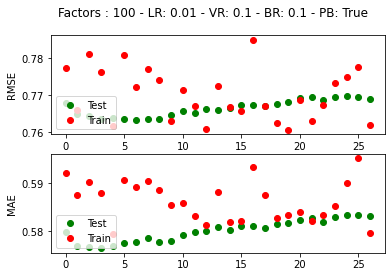

New best params: {'Factors': 100, 'Learning Rate': 0.01, 'Populate Bias': True, 'Bias Regs': 0.1, 'Vector Regs': 0.1, 'Epochs': 3}
Using hyperparams: {'Factors': 100, 'Learning Rate': 0.01, 'Populate Bias': True, 'Bias Regs': 0.1, 'Vector Regs': 0.2, 'Epochs': 3}


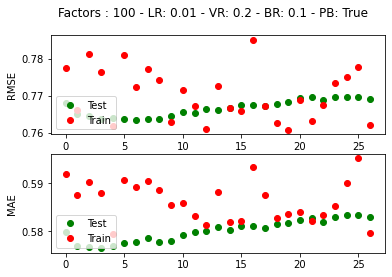

New best params: {'Factors': 100, 'Learning Rate': 0.01, 'Populate Bias': True, 'Bias Regs': 0.1, 'Vector Regs': 0.2, 'Epochs': 3}
Using hyperparams: {'Factors': 100, 'Learning Rate': 0.01, 'Populate Bias': True, 'Bias Regs': 0.2, 'Vector Regs': 0.1, 'Epochs': 3}


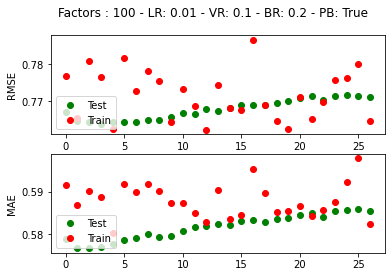

Using hyperparams: {'Factors': 100, 'Learning Rate': 0.01, 'Populate Bias': True, 'Bias Regs': 0.2, 'Vector Regs': 0.2, 'Epochs': 3}


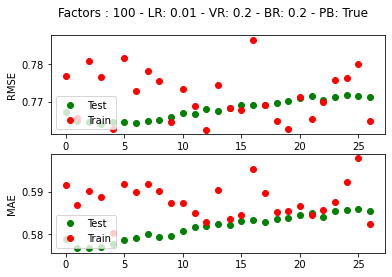

Using hyperparams: {'Factors': 100, 'Learning Rate': 0.001, 'Populate Bias': True, 'Bias Regs': 0.1, 'Vector Regs': 0.1, 'Epochs': 3}


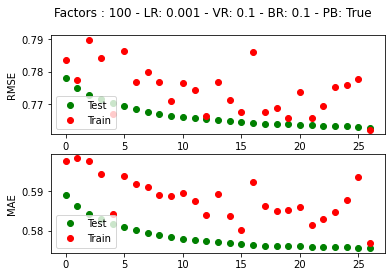

New best params: {'Factors': 100, 'Learning Rate': 0.001, 'Populate Bias': True, 'Bias Regs': 0.1, 'Vector Regs': 0.1, 'Epochs': 3}
Using hyperparams: {'Factors': 100, 'Learning Rate': 0.001, 'Populate Bias': True, 'Bias Regs': 0.1, 'Vector Regs': 0.2, 'Epochs': 3}


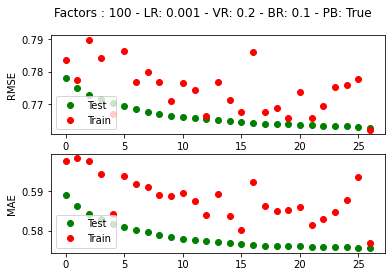

New best params: {'Factors': 100, 'Learning Rate': 0.001, 'Populate Bias': True, 'Bias Regs': 0.1, 'Vector Regs': 0.2, 'Epochs': 3}
Using hyperparams: {'Factors': 100, 'Learning Rate': 0.001, 'Populate Bias': True, 'Bias Regs': 0.2, 'Vector Regs': 0.1, 'Epochs': 3}


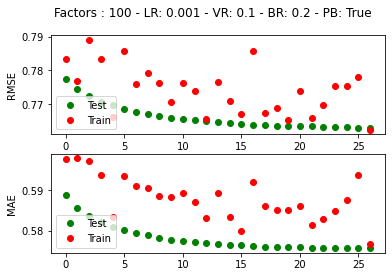

New best params: {'Factors': 100, 'Learning Rate': 0.001, 'Populate Bias': True, 'Bias Regs': 0.2, 'Vector Regs': 0.1, 'Epochs': 3}
Using hyperparams: {'Factors': 100, 'Learning Rate': 0.001, 'Populate Bias': True, 'Bias Regs': 0.2, 'Vector Regs': 0.2, 'Epochs': 3}


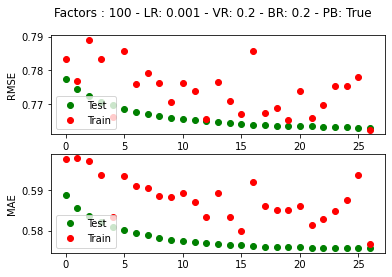

New best params: {'Factors': 100, 'Learning Rate': 0.001, 'Populate Bias': True, 'Bias Regs': 0.2, 'Vector Regs': 0.2, 'Epochs': 3}
Best parameters: {'Factors': 100, 'Learning Rate': 0.001, 'Populate Bias': True, 'Bias Regs': 0.2, 'Vector Regs': 0.2, 'Epochs': 3}, RMSE: 0.763


In [3]:
test_params()

The test RMSE value was used to determine which set of hyperparameters performed the best. From our results we see that it appears that within the ranges of hyperparameters we tested here a higher regularization term and low learning rate lead to the best results.

### Neural Net

We can also generate predicitions by training a neural net on the available data. This method uses the embeddings module of PyTorch to map user and item entries to embedding vectors. The concatentation of these two vectors is used as the input to our forward function, which is fed through a selected amount of hidden, and dropout layers, and used to generate a prediction for the specified user and item combination.

In [4]:
import math
import numpy as np
import torch
import data
import itertools
from sklearn.model_selection import train_test_split
import copy
from torch.optim.lr_scheduler import _LRScheduler
import pickle

class my_net(torch.nn.Module):
    def __init__(self, n_users, n_items, u_embeds, i_embeds, hidden_sizes = [500, 500, 500], drop_rates = [.5, 0.5, .25], embed_drop = .05):
        super(my_net, self).__init__()
        self.user_embeds = torch.nn.Embedding(n_users, u_embeds)
        self.item_embeds = torch.nn.Embedding(n_items, i_embeds)
        
        def make_hidden(n_in): # generator to create hidden layers
                
                nonlocal hidden_sizes, drop_rates
                assert len(drop_rates) <= len(hidden_sizes)
                
                for n_out, rate in itertools.zip_longest(hidden_sizes, drop_rates):
                    yield torch.nn.Linear(n_in, n_out)
                    yield torch.nn.ReLU()
                    if rate is not None and rate > 0.:
                        yield torch.nn.Dropout(rate)
                    n_in = n_out 

        self.embed_drop = torch.nn.Dropout(embed_drop)
        self.hidden = torch.nn.Sequential(*list(make_hidden(u_embeds + i_embeds)))
        self.out_layer = torch.nn.Linear(hidden_sizes[-1], 1)
        self._init()


    def forward(self, user, item):
        x = torch.cat([self.user_embeds(user), self.item_embeds(item)], dim=1)
        x = self.embed_drop(x)
        x = self.hidden(x)
        x = self.out_layer(x)
        x = torch.sigmoid(x)

        return x
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == torch.nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        weight = .01
        self.user_embeds.weight.data.uniform_(-1 *weight, weight)
        self.item_embeds.weight.data.uniform_(-1 * weight, weight)
        self.hidden.apply(init)
        init(self.out_layer)
    
class batch_iterator:
    def __init__(self, x, y, shuffle = True, bs = 32):
        if shuffle:
            p = np.random.permutation(x.shape[0])
            self.x, self.y = x[p], y[p]
        else:
            self.x, self.y = x, y
            
        self.max_batch = x.shape[0] // bs
        self.bc = 0
        self.bs = bs
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.bc < self.max_batch:
            bc = self.bc
            self.bc += 1
            return self.x[bc * self.bs: (bc + 1) * self.bs], self.y[bc * self.bs: (bc + 1) * self.bs]
        else:
            raise StopIteration()
            
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]



def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

def train_model(norm = 'mm'):

    ratings = data.get_data("ml-latest-small/ratings.csv").to_numpy()
    
    y = ratings[~np.isnan(ratings)]
    
    # ratings = (ratings - y.mean()) / y.std()
    # y = (y - y.mean()) / y.std()
    
    if norm == 'mm': # minmax scaling
        y = (y - y.min()) / (y.max() - y.min())
    elif norm == 'z': # z scaling
        y = (y - y.mean()) / y.std()
    
    x = np.column_stack(np.nan_to_num(ratings).nonzero())
    
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=1)
    
    datasets = {
        "train": (x_train, y_train),
        "val": (x_valid, y_valid)
        }
    
    
    n_users, n_items = ratings.shape
    
    u_embeds, i_embeds = 150, 150
    
    lr = 5e-4
    wd = 1e-1
    bs = 2000
    n_epochs = 100
    patience = 10
    no_improvements = 0
    best_loss = np.inf
    best_weights = None
    history = []
    
    # use GPU if available
    identifier = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    device = torch.device(identifier)
    
    base = 500
    net = my_net(n_users, n_items, u_embeds, i_embeds, [base, base, base], [.5, .5, .25])
    net.to(device)
    print(net)
    criterion = torch.nn.MSELoss(reduction='sum')
    #criterion = torch.nn.L1Loss(reduction='sum')
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    iterations_per_epoch = int(math.ceil(datasets['train'][0].shape[0] // bs))
    scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))
    lr_history = []
    
    fmt = '[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'
    
    # start training
    for epoch in range(n_epochs):
        stats = {'epoch': epoch + 1, 'total': n_epochs}
        
        for phase in ('train', 'val'):
            if phase == 'train':
                net.train()
            else:
                net.eval()
            training = phase == 'train'
            running_loss = 0.0
            
            itr = batch_iterator(*datasets[phase], bs = bs)
            
            for x_b, y_b in itr:
                optimizer.zero_grad()
                x_b_t = torch.LongTensor(x_b).to(device)
                y_b_t = torch.FloatTensor(y_b).view(-1, 1).to(device)
                preds = net(x_b_t[:, 0], x_b_t[:, 1])
                loss = criterion(preds, y_b_t)
                if training:
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
                    lr_history.extend(scheduler.get_lr())
                
                        
                running_loss += loss.item()
                
            epoch_loss = running_loss / datasets[phase][0].shape[0]
            stats[phase] = epoch_loss
            if phase == 'val':
                if epoch_loss < best_loss:
                    print('loss improvement on epoch: %d' % (epoch + 1))
                    best_loss = epoch_loss
                    best_weights = copy.deepcopy(net.state_dict())
                    no_improvements = 0
                else:
                    no_improvements += 1
                    
        history.append(stats)
        print(fmt.format(**stats))
    
        if no_improvements >= patience:
            break
        
    net.load_state_dict(best_weights)
        
    torch.save(best_weights, "models/best_weights.pt")
    pickle.dump(net.user_embeds, open("models/user_embeds", "wb"))
    pickle.dump(net.item_embeds, open("models/item_embeds", "wb"))

The above code contains our net model as well as functions required for the training loop, including a batch iterator class, and a learning rate scheduler. The code was based off the blog post [here](https://medium.com/coinmonks/how-to-implement-a-recommendation-system-with-deep-learning-and-pytorch-2d40476590f9), so anyone interested in how exactly each part works can find what they are looking for in the post itself.

It's certainly a nice algorithm, but there's not as much here that merits a low-level explaination of the inner workings as it's mostly quite standard for those familiar with the process of training neural nets, so in the interest of brevity let's just go ahead and train the thing.

In [5]:
train_model()

my_net(
  (user_embeds): Embedding(610, 150)
  (item_embeds): Embedding(9724, 150)
  (embed_drop): Dropout(p=0.05, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
  )
  (out_layer): Linear(in_features=500, out_features=1, bias=True)
)
loss improvement on epoch: 1
[001/100] train: 0.0508 - val: 0.0417
loss improvement on epoch: 2
[002/100] train: 0.0380 - val: 0.0388
loss improvement on epoch: 3
[003/100] train: 0.0357 - val: 0.0375
loss improvement on epoch: 4
[004/100] train: 0.0328 - val: 0.0374
loss improvement on epoch: 5
[005/100] train: 0.0331 - val: 0.0367
loss improvement on epoch: 6
[006/100] train: 0.0311 - val: 0.0367
loss improvement on 

### Analysis

Now we have two different methods from predicting user-item interactions. A good indication that the processes worked well would be that they make similar predictions, and that they group the users and items similarly.

In [6]:
from scipy.spatial import cKDTree
import sgd_mf
import nn
import random

def load_mf_embeds():
    user_vec = pickle.load(open("mf_emeddings/user_matrix", "rb" ))
    item_vec = pickle.load(open("mf_emeddings/item_matrix", "rb" ))
    
    return user_vec, item_vec

def load_nn_embeds():
    users = pickle.load(open("models/user_embeds", "rb" ))
    items = pickle.load(open("models/item_embeds", "rb" ))
    
    return users.cpu().weight.detach().numpy(), np.array(items.cpu().weight.detach().numpy())

def get_n_closest(in_matrix, i, n = 5):
    search_vec = in_matrix[i] # get value to be compared
    ret_matrix = cKDTree(in_matrix).query(search_vec, k = n + 1)
    return ret_matrix[0][1::], ret_matrix[1][1::] # remove most similar entry i.e. itself
    

def content_based(use_nn = True):
    item_vecs = load_nn_embeds()[1] if use_nn else load_mf_embeds()[1]
    
    movies = data.get_data_raw("ml-latest-small/movies.csv").to_numpy()
    
    for i in range(10):
        n_closest = get_n_closest(item_vecs, i)
        recommendations = movies[n_closest[1]]
        print("For: {}\n".format(movies[i][1]))
        print("{}\n".format(recommendations))

Here our content_based method takes the embeddings either from the neural net model, or the matrix factorization model. We can use either of these embeddings and use them to find similar movies, the idea being that similar movies will tend to have similar embedding vectors, and that by finding the closest movies to a given entry, we can make recommendations to a new user which the system has not yet created an accurate vector for. The process simply takes a specified movie, loads the embedding and finds the n closest embeddings, and prints the titles.

In [7]:
content_based()

For: Toy Story (1995)

[[173351 'Wow! A Talking Fish! (1983)'
  'Animation|Children|Comedy|Fantasy']
 [57504 'Girl Who Leapt Through Time, The (Toki o kakeru shôjo) (2006)'
  'Animation|Comedy|Drama|Romance|Sci-Fi']
 [64249 'Shrek the Halls (2007)' 'Adventure|Animation|Comedy|Fantasy']
 [25963 'Young and the Damned, The (Olvidados, Los) (1950)' 'Crime|Drama']
 [62434 'Zack and Miri Make a Porno (2008)' 'Comedy|Drama|Romance']]

For: Jumanji (1995)

[[58047 'Definitely, Maybe (2008)' 'Comedy|Drama|Romance']
 [7109 'Beyond the Clouds (Al di là delle nuvole) (1996)' 'Drama|Romance']
 [30707 'Million Dollar Baby (2004)' 'Drama']
 [45662 'Omen, The (2006)' 'Horror|Thriller']
 [84246 'It Happened on Fifth Avenue (1947)' 'Comedy|Romance']]

For: Grumpier Old Men (1995)

[[84246 'It Happened on Fifth Avenue (1947)' 'Comedy|Romance']
 [27549 'Dead or Alive: Final (2002)'
  'Comedy|Crime|Drama|Sci-Fi|Thriller']
 [142444 'The Editor (2015)' 'Comedy|Horror|Mystery']
 [78746 'Best Worst Movie (2009

In [8]:
def compare_preds_random(u_range = 10, i_range = 10, mf_index = True): # find difference between predicted rankings of movies generated by each method
    diff_array = np.zeros(u_range)
    user_count, item_count = data.get_data("ml-latest-small/ratings.csv").shape
    for i, u_id in enumerate(random.sample(range(user_count), u_range)):
        mf_preds = sgd_mf.get_predictions(u_id, 0, False)
        nn_preds = nn.get_predictions(u_id, 0, False)
        
        if mf_index:
            index, query = mf_preds[:,0], nn_preds[:,0]
        else:
            index, query = nn_preds[:,0], mf_preds[:,0]
            
        diff_sum = 0
        for i_id in random.sample(range(index.shape[0]), min(i_range, index.shape[0])):
            m_id = index[i_id]
            q_index = np.where(query == m_id)[0][0]
            diff_sum += abs(q_index - i_id)
        
        avg = diff_sum / i_range
        diff_array[i] = avg
        print("User {} Average difference in rank is {}".format(u_id, round(avg, 2)))
    print("Average difference: {}, Item Range: {}".format(round(diff_array.mean(), 2), item_count))

This last function compares prediction rankings generated using each of the two models. Each of the get_predictions methods returns an ordered list of predictions for every item, given a specified user id. A random sample of items is then selected from one of the lists, and we find the difference in ranking for the item to it's place in the opposite list. This process is repeated for a specified number of users.

By using this method, we can find which combinations of hyperparameters, neural net models, and data formatting produce the most similar predictions, which is useful information as we can assume that as our models become more similar, they are likely becoming more accurate.

I was surprised to find at this point that a neural net model trained on z-normalized data correlated stronger to the minmax normalized matrix factorization method than a neural net model trained using minmax-normalized data. One would be tempted to think that because the data used for training was formatted in the same way, the the results might be more similar. However since we are measuring similarity in the order of ranked predictions, and not the predictions scores themselves, we can use this method as a way of discovering which data formats, or other similar variables, lead to the most consistent results.

In [9]:
compare_preds_random()

User 462 Average difference in rank is 1850.5
User 125 Average difference in rank is 931.2
User 245 Average difference in rank is 1116.2
User 66 Average difference in rank is 1659.0
User 328 Average difference in rank is 853.2
User 511 Average difference in rank is 552.2
User 45 Average difference in rank is 1100.4
User 301 Average difference in rank is 1127.8
User 596 Average difference in rank is 1110.7
User 436 Average difference in rank is 1371.3
Average difference: 1167.25, Item Range: 9724
